In [2]:
import numpy as np
import pandas as pd
import torch
from transformers import PatchTSMixerConfig, PatchTSMixerForPrediction

# 1. Generate Synthetic OSRS-like Time Series (e.g., High Price of an item)
def generate_data(n_steps=1000):
    time = np.arange(n_steps)
    # Sine wave + Trend + Noise
    prices = 1000 + 100 * np.sin(time / 20) + 0.5 * time + np.random.normal(0, 10, n_steps)
    return pd.DataFrame({"timestamp": time, "high": prices})

df = generate_data()

# 2. Configuration for PatchTSMixer
# Context length: how many past points to look at (e.g., 512 minutes)
# Prediction length: how many future points to predict (e.g., 96 minutes)
config = PatchTSMixerConfig(
    context_length=512,
    prediction_length=96,
    patch_length=16,
    num_input_channels=1,
    patch_stride=16,
    d_model=16,
    num_layers=2,
    expansion_factor=2,
    dropout=0.1,
    head_dropout=0.1,
    mode="common_channel",
)

# 3. Initialize Model
model = PatchTSMixerForPrediction(config)

# 4. Prepare a dummy batch (Batch Size=1, Context=512, Channels=1)
# PatchTSMixer expects [batch_size, sequence_length, num_channels]
dummy_input = torch.randn(1, 512, 1)

# 5. Forward Pass
with torch.no_grad():
    outputs = model(past_values=dummy_input)

print(f"Prediction Shape: {outputs.prediction_outputs.shape}")
# Should output: [1, 96, 1] -> 1 batch, 96 minutes predicted, 1 channel

Prediction Shape: torch.Size([1, 96, 1])


In [3]:
import pandas as pd

In [4]:
CSV_PATH = "/Users/marcusfranz/Documents/gept/item_2_1min_data.csv"

In [5]:
df = pd.read_csv(CSV_PATH)

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

In [7]:
# === Device Setup ===
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✓ Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("✓ Using NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("⚠ Using CPU")

torch.manual_seed(42)
if device.type == "mps":
    torch.mps.manual_seed(42)

print(f"PyTorch version: {torch.__version__}")

✓ Using Apple Silicon GPU (MPS)
PyTorch version: 2.10.0


In [8]:
# Device Setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device:", device)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using device:", device)
else:
    print("Using cpu")
    device = torch.device("cpu")
# Reproducibility
torch.manual_seed(42)
if device.type == "mps":
    torch.mps.manual_seed(42)
print(torch.__version__)

Using device: mps
2.10.0


In [9]:
from numpy.lib.stride_tricks import sliding_window_view
df['spread'] = df['high'] - df['low']
df['mid'] = (df['high'] + df['low']) / 2
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['velocity'] = df['high'].diff().fillna(0)
df['volatility'] = df['high'].rolling(10).std()
df = df.dropna().reset_index(drop=True)
feature_cols = ['high', 'spread', 'velocity', 'volatility']
features = df[feature_cols].values
context_len = 90
pred_len = 10
total_len = context_len + pred_len
windows = sliding_window_view(features, window_shape=total_len, axis=0).transpose(0, 2, 1) #90 + 10
x = windows[:, :context_len, :]
y = windows[:, context_len:, 0:1]

In [10]:
print(x[0,0,3])

4.083843505544476


In [11]:
# Train/test split
split_idx = int(len(x) * 0.8)
x_train, x_test = x[:split_idx], x[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Get last context value for each sample (the anchor point)
x_train_last = x_train[:, -1:, 0:1]  # Shape: (samples, 1, 1) - last high price
x_test_last = x_test[:, -1:, 0:1]

# Normalize X features using global stats (features have different scales)
x_mean = x_train.mean(axis=(0, 1), keepdims=True)
x_std = x_train.std(axis=(0, 1), keepdims=True)
x_train_norm = (x_train - x_mean) / x_std
x_test_norm = (x_test - x_mean) / x_std

# Normalize Y as DIFFERENCE from last context value (local normalization)
y_train_diff = y_train - x_train_last
y_test_diff = y_test - x_test_last

# Scale the differences
y_diff_std = y_train_diff.std()
y_train_norm = y_train_diff / y_diff_std
y_test_norm = y_test_diff / y_diff_std

print(f"y_diff_std: {y_diff_std:.4f}")  # Save this for denormalization

y_diff_std: 3.8320


In [12]:
#x_train = (np.expand_dims(x_train, axis=-1) - mean) / std
#y_train = (np.expand_dims(y_train, axis=-1) - mean) / std
#x_test = (np.expand_dims(x_test, axis=-1) - mean) / std
#y_test = (np.expand_dims(y_test, axis=-1) - mean) / std

In [13]:
x_train_t = torch.tensor(x_train_norm, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_norm, dtype=torch.float32).to(device)
x_test_t = torch.tensor(x_test_norm, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test_norm, dtype=torch.float32).to(device)

# Keep last values for denormalization later
x_test_last_t = torch.tensor(x_test_last, dtype=torch.float32).to(device)

In [14]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(x_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(x_test_t, y_test_t)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
config = PatchTSMixerConfig(
    context_length=90,
    prediction_length=10,
    patch_length=10,
    num_input_channels=len(feature_cols),
    num_targets=1,
    patch_stride=10,
    d_model=64,
    num_layers=4,
    expansion_factor=4,
    dropout=0.1,
    head_dropout=0.2,
    mode="common_channel",
)

model = PatchTSMixerForPrediction(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss= 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(past_values=batch_x)
        predictions = outputs.prediction_outputs[:, :, 0:1]
        loss = torch.nn.functional.mse_loss(predictions, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch}: Train loss: {avg_loss:.4f}")


Epoch 0: Train loss: 1.7883
Epoch 1: Train loss: 1.5573
Epoch 2: Train loss: 1.4606
Epoch 3: Train loss: 1.4342
Epoch 4: Train loss: 1.4233
Epoch 5: Train loss: 1.4154
Epoch 6: Train loss: 1.3970
Epoch 7: Train loss: 1.3833
Epoch 8: Train loss: 1.3652
Epoch 9: Train loss: 1.3526
Epoch 10: Train loss: 1.3443
Epoch 11: Train loss: 1.3280
Epoch 12: Train loss: 1.3063
Epoch 13: Train loss: 1.3022
Epoch 14: Train loss: 1.2855
Epoch 15: Train loss: 1.2778
Epoch 16: Train loss: 1.2690
Epoch 17: Train loss: 1.2560
Epoch 18: Train loss: 1.2483
Epoch 19: Train loss: 1.2314


Last context value: 213.00
Predicted: [211.79437284 211.79296222 212.05152261 211.65192681 212.31975701
 212.71057643 212.56078222 212.35902885 212.51038351 212.98738736]
Actual: [218. 218. 218. 218. 219. 219. 219. 219. 215. 214.]


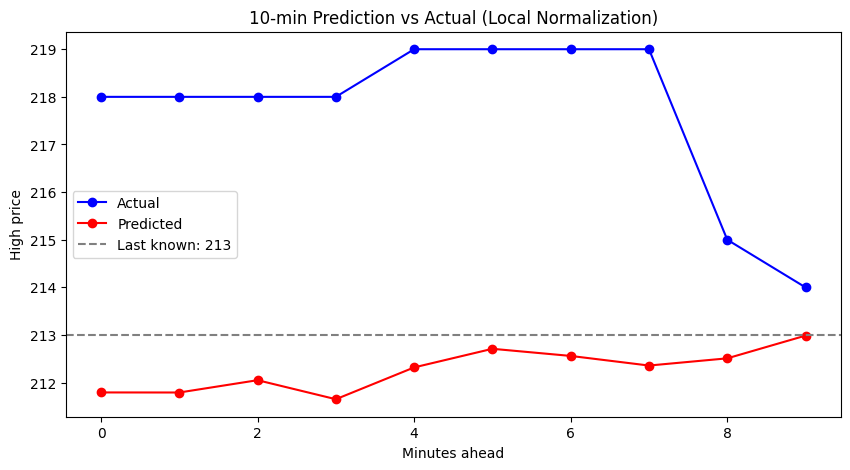

In [17]:
model.eval()
sample_idx = 20

with torch.no_grad():
    sample_x = x_test_t[sample_idx:sample_idx+1]
    pred = model(past_values=sample_x).prediction_outputs[:, :, 0:1]
    pred_np = pred.cpu().numpy()
    
    # Get the last context value (anchor) for this sample
    last_val = x_test_last[sample_idx, 0, 0]
    
    # Denormalize: unscale, then add anchor
    pred_real = (pred_np * y_diff_std) + last_val
    
    # Same for actual
    actual_norm = y_test_norm[sample_idx:sample_idx+1]
    actual_real = (actual_norm * y_diff_std) + last_val
    
    # Flatten for plotting
    pred_real = pred_real.flatten()
    actual_real = actual_real.flatten()
    
    print(f"Last context value: {last_val:.2f}")
    print(f"Predicted: {pred_real}")
    print(f"Actual: {actual_real}")

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(actual_real, 'b-o', label="Actual")
    plt.plot(pred_real, 'r-o', label="Predicted")
    plt.axhline(y=last_val, color='gray', linestyle='--', label=f"Last known: {last_val:.0f}")
    plt.legend()
    plt.xlabel("Minutes ahead")
    plt.ylabel("High price")
    plt.title("10-min Prediction vs Actual (Local Normalization)")
    plt.show()

In [ ]:
print(f"Prediction std: {np.std(pred_real):.2f}")
print(f"Actual std: {np.std(actual_real):.2f}")

In [44]:
naive_pred = x_test[:, -1:, :]
naive_pred = np.tile(naive_pred, (1, 10, 1))
naive_mse = np.mean((naive_pred - y_test) ** 2)
print(f"naive mse: {naive_mse:.4f}")

naive mse: 0.2974
